# Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [3]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [5]:
# TODO: Load read and load the data here
df = pd.read_csv('twitter-suicidal-data.csv')
df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


## Data Preprocessing

In [6]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javadpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\javadpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\javadpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\javadpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
def convert_emoji_to_text(text):
  emoji_pattern = re.compile(
        '['
        '\U0001F600-\U0001F64F'  # emoticons
        '\U0001F300-\U0001F5FF'  # symbols & pictographs
        '\U0001F680-\U0001F6FF'  # transport & map symbols
        '\U0001F1E0-\U0001F1FF'  # flags (iOS)
        '\U00002700-\U000027BF'  # dingbats
        '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        '\U00002600-\U000026FF'  # Miscellaneous Symbols
        '\U0001F018-\U0001F270'  # Various Asian characters
        '\U0001F004-\U0001F0CF'  # Playing cards
        '\U0001F0A0-\U0001F0FF'  # Playing cards continued
        '\U00002B50-\U00002B50'  # Stars
        '\U0001F004-\U0001F004'  # Mahjong tile
        '\U0001F0CF-\U0001F0CF'  # Joker
        '\U0001F170-\U0001F251'  # Enclosed characters
        '\U0001F004-\U0001F0CF'  # More Mahjong tiles
        '\U00002B06-\U00002B07'  # Arrows
        ']+'
    )
  return emoji_pattern.sub(" ", text)


stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    # TODO: lowercase the text
    text = text.lower()
    # TODO: remove usernames
    text = re.sub(r'@\w+', ' ', text)
    # TODO: remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # TODO: remove numbers
    text = re.sub(r'-?\b\d+(\.\d+)?\b', '', text)
    # TODO: remove urls,
    text = re.sub(r'\b(?:http://|https://|www\.|http)[^/\s]+\b', '', text)
    # TODO: remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # TODO: convert emojis to text
    text = convert_emoji_to_text(text)
    # TODO: remove non-word characters
    text = re.sub(r'\W+', ' ', text)
    # TODO: lemmatization and tokenization of the text
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, nltk_pos_tagger(tag)) for token, tag in pos_tags]
    # TODO: remove stopwords
    tokens = [token for token in lemmatized_tokens if token.lower() not in stopwords]
    return tokens


## Questions on preprocessing
> 1-pros and cons of converting text to lowercase
>> pros:
>>> 1-Uniformity: Converting text to lowercase ensures uniformity, reducing the number of unique tokens in the dataset. For instance, "Apple," "apple," and "APPLE" will all be considered the same token.

>>> 2-Simplified Processing: By having all text in lowercase, it simplifies text processing and analysis, as the need to handle case variations is eliminated. This is particularly beneficial for tasks like tokenization, stemming, and lemmatization.

>>> 3-Improved Model Performance: Uniform text can lead to better model performance, particularly in models that rely on word counts or frequency-based features. It helps in reducing sparsity in the feature space.

>>> 4-Reduced Overfitting: Lowercasing can help in reducing overfitting, especially in models sensitive to textual variations. This is because it prevents the model from learning case-specific patterns that may not generalize well.

>> cons:
>>> 1-Loss of Information: Converting text to lowercase results in the loss of case-specific information. Proper nouns, acronyms, and other case-sensitive nuances are no longer distinguishable, which might be crucial in certain contexts

>>>2-Impact on Sentiment Analysis: In sentiment analysis, the casing of words can sometimes carry sentiment information

>>>3-Handling Mixed-Cased Contexts: Some domains, like legal or medical texts, might have specific meanings or conventions associated with different cases. Lowercasing can strip away important contextual clues.

>>>4-Challenges with Certain Languages: In some languages, case might play a more significant role than in English. For example, in German, nouns are capitalized, and lowercasing them might lead to ambiguity or loss of grammatical structure.

>2-removing numbers from text
>> pros:
>>> 1-Reduction of Noise: In many cases, numbers can be considered noise, especially if they do not contribute meaningful information to the text. Removing them can help focus on the core textual content.

>>> 2-Simplified Tokenization: Removing numbers can simplify tokenization and other preprocessing steps. It avoids potential complications with number formats

>>> 3-Dimensionality Reduction: Eliminating numbers can reduce the dimensionality of the feature space, which might help in improving the efficiency and performance of models, especially in algorithms that rely on token frequency

>>> 4-Improved Generalization: By removing numbers, the model might generalize better, focusing on the textual context rather than potentially overfitting to specific numerical patterns.

>> cons
>>> 1- Loss of Information: Numbers often carry significant information. For example, dates, quantities, prices, and other numerical data can be crucial for understanding the context and meaning of the text. Removing them can lead to loss of important information.

>>> 2-Contextual Importance: In domains like finance, medicine, or scientific texts, numbers are integral to the content. Removing them can severely impact the quality and accuracy of the analysis.

>>> 3-Reduced Specificity: Numbers can provide specific details that differentiate between otherwise similar texts. Their removal might reduce the specificity and richness of the information.

>>> 4-Potential Misinterpretation: Some texts might have words that include numbers or have meaning linked to numbers

>3-why keeping hashtags?
>>  Hashtags provide contextual information that can be crucial for understanding the content and sentiment of a tweet

In [8]:
import random
indices = random.sample(range(len(df)), 10)
for idx in indices:
    text = df.iloc[idx, 0]
    print("Initial text : ", text)
    print("Preprocessed text : ", preprocess_data(text))

Initial text :  am i depressed or am i just looking for attention i definitely have anxiety and i think i have some kind of borderline disorder when i get this way all i do is lay down or talk about how i should kill myself i dont think id ever actually do it because my family loves me but ive noticed myself doing it just to make people notice is it all just made up in the back of my head to get peoples attention
Preprocessed text :  ['depress', 'look', 'attention', 'definitely', 'anxiety', 'think', 'kind', 'borderline', 'disorder', 'get', 'way', 'lay', 'talk', 'kill', 'dont', 'think', 'id', 'ever', 'actually', 'family', 'love', 'ive', 'notice', 'make', 'people', 'notice', 'make', 'back', 'head', 'get', 'people', 'attention']
Initial text :  are sleeping pills good enough exactly what the question asks would they kill me if i take a lot i am getting desperate and i dont know if i want to run around until i find a roof high enough to jump off from i dont think i have the balls for it 
P

In [9]:
def get_number_of_tokens(text):
    return len(preprocess_data(text))

In [10]:
df['tokens'] = df['tweet'].apply(get_number_of_tokens)

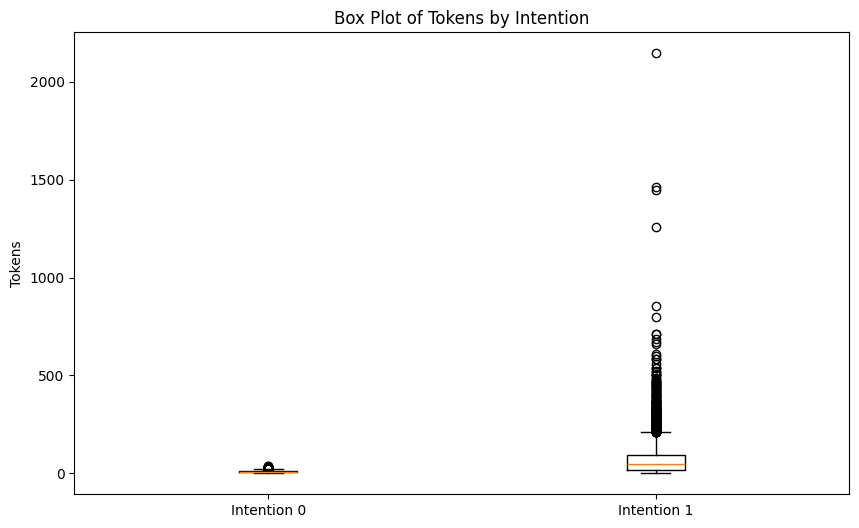

In [11]:
intention_0 = df[df['intention'] == 0]['tokens']
intention_1 = df[df['intention'] == 1]['tokens']

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot([intention_0, intention_1], labels=['Intention 0', 'Intention 1'])
plt.title('Box Plot of Tokens by Intention')
plt.ylabel('Tokens')
plt.show()

# Word2Vec - Word Embedding

In [12]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [13]:
W2V_PATH = "models"
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [14]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size
# w2v_model['javad'] -> NA

# Dataset

In [37]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
      # TODO: Return a 2D tensor for whole list of tokens, using vectors from w2v as explained on the description
        vectors = np.empty((self.max_sequence_len, 300))
        for idx, token in enumerate(tokens):
            if token in self.w2v_model:
                vectors[idx] = self.w2v_model[token]
            else:
                vectors[idx] = np.zeros(self.vector_size)
        return self._to_tensor(vectors)            



    def _pad(self, tokens: list):
        # TODO: Add paddings (zero-vectors) into the end of sequence to reach the desired length
        if len(tokens) < self.max_sequence_len:
            tokens.extend(['javad'] * (self.max_sequence_len - len(tokens)))
        else:
            tokens = tokens[:self.max_sequence_len]
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

## How to handle the case where the word is not present in the dictionary?
> 1-Default vector
>> pros
>>> Simplicity: Easy to implement and understand.

>>> Consistency: Provides a consistent approach to handling all out of vocabulary words.

>> cons
>>> Lack of Information: A zero or random vector does not provide any useful information about the word.

>>> Reduced Accuracy: May degrade model performance because it does not capture any semantic similarity.

> 2- Predefined out of vocabulary Token
>> pros:

>>> Simplicity: Easy to implement by adding a special token to the vocabulary.

>>> Uniform Handling: Treats all out of vocabulary words uniformly, which can be useful for consistency.

>> Cons:
>>> Generic Representation: All out of vocabulary words are mapped to the same vector, which might not capture subtle distinctions.

>>> Potential Overuse: If many words are out of vocabulary, the OOV token might become too common and skew the results.


# Prepare Data

## Split Data into train-valid

In [16]:
# TODO: Split dataset into train-test split
indexes = np.arange(len(df))
X_train_idx, X_test_idx = train_test_split(indexes, test_size=0.2, random_state=42)

I used $20\%$ test size for splitting the data into training and test sets.An 80-20 split strikes a balance between having sufficient data for training the model (80%) and reserving a substantial portion for evaluating its performance (20%). With this split, the model learns from the majority of the data while still having a sizable test set to assess generalization. By reserving a larger portion of the data for training (80%), the model has more instances to learn from, potentially reducing the risk of overfitting. A smaller test set (20%) helps detect overfitting by providing a more accurate estimate of the model's performance on unseen data.

## Create Datasets

In [17]:
# TODO: create twitter dataset
train_dataset = Twitter(
    df.iloc[X_train_idx],
    w2v_model=w2v_model,
    sequence_len=SEQUENCE_LEN
)
valid_dataset = Twitter(
    df.iloc[X_test_idx],
    w2v_model=w2v_model,
    sequence_len=SEQUENCE_LEN
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2011463332.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2011463332.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Deleted 0-Len Samples: 23


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2011463332.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2011463332.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2011463332.py:35: SettingWithCopyWarning: 
A value is tryi

Deleted 0-Len Samples: 8
Train dataset length: 7272
Valid dataset length: 1816


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2011463332.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


# Model and Train

## Utils

In [18]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: str=('cuda', 'cpu', 'auto')):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # Move model's inputs to `device`
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Use model's forward pass to generate outputs
        outputs = model(inputs)
        
        # Calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # Calculate/update model's accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct_predictions = (predictions == labels).sum().item()
        test_acc += correct_predictions / labels.size(0)

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )

    return test_loss, test_acc

In [19]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device='auto'
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # Create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        itr = tqdm(train_loader, total=len(train_loader), leave=False)

        for idx, (inputs, labels) in enumerate(itr, start=1):
            # Move model's inputs to `device`
            inputs = inputs.to(device)
            labels = labels.to(device)

            

            # Use model's forward pass to generate outputs
            outputs = model(inputs)

            # Process model's predictions and calculate/update accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions = (predictions == labels).sum().item()
            epoch_acc += correct_predictions / labels.size(0)

            # Calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(epoch_acc / idx, 5),  # Update display accuracy
            )

            epoch_loss += loss.item()

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )

        # Update statistics regarding model's loss and accuracy in training or validation phases
        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc / len(train_loader))

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accs.append(valid_acc / len(valid_loader))

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_loss": valid_losses,
        "valid_acc": valid_accs,
    }
    return history


In [20]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [21]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    predicted = []

    for inputs, targets in itr:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        labels.extend(targets.cpu().numpy())
        predicted.extend(preds.cpu().numpy())

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

Here the input channels of our CNN is 300 which means the kernel aggregates all 300 features of the sentence vector;though the kernel size specifies the number of words that are looked togeather.

In convolutional neural networks (CNNs), decreasing the output size of convolutional layers is typically achieved through techniques like pooling layers or adjusting the stride of the convolution operation. While it's possible to decrease the output size directly within the convolutional layers, this approach is less common for several reasons:
* Feature Extraction and Spatial Hierarchies: Convolutional layers are designed to extract features and spatial hierarchies from the input data. Decreasing the output size within convolutional layers would reduce the spatial information available to subsequent layers, potentially limiting the model's ability to capture complex patterns and relationships in the data.
* Translation Invariance: CNNs leverage translation invariance, meaning they can detect patterns regardless of their location in the input data. Pooling layers, which are commonly used to decrease the output size of convolutional layers, help enhance translation invariance by aggregating information over local regions of the input data while preserving important features.
* Parameter Efficiency: Decreasing the output size directly within convolutional layers would require additional learnable parameters (e.g., learnable downsampling filters), which could increase model complexity and computational cost. Using pooling layers or adjusting the stride of convolutional operations achieves downsampling efficiently without introducing additional parameters.

* Feature Hierarchies: CNNs typically consist of multiple layers arranged in a hierarchical fashion, with each layer capturing increasingly abstract and high-level features. By maintaining spatial information in convolutional layers and downsampling only at specific points (e.g., using pooling layers), CNNs can build rich feature hierarchies that capture both local and global information in the input data.

In [34]:
class CNN(nn.Module):
    def __init__(self, sequence_len):
        super(CNN, self).__init__()

        # Define your network's layers here
        self.conv1_1 = nn.Conv1d(300, 64, 3)
        self.conv1_2 = nn.Conv1d(64, 128, 3)
        self.max_pool_1 = nn.MaxPool1d(kernel_size=sequence_len - 4)

        self.conv2_1 = nn.Conv1d(300, 64, 5)
        self.conv2_2 = nn.Conv1d(64, 128, 5)
        self.max_pool_2 = nn.MaxPool1d(kernel_size=sequence_len - 8)

        self.conv3_1 = nn.Conv1d(300, 64, 7)
        self.conv3_2 = nn.Conv1d(64, 128, 7)
        self.max_pool_3 = nn.MaxPool1d(kernel_size=sequence_len - 12)

        # Fully connected layers
        self.fc1 = nn.Linear(3 * 128, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        # First branch
        x1 = torch.relu(self.conv1_1(x))
        x1 = torch.relu(self.conv1_2(x1))
        x1 = self.max_pool_1(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten

        # Second branch
        x2 = torch.relu(self.conv2_1(x))
        x2 = torch.relu(self.conv2_2(x2))
        x2 = self.max_pool_2(x2)
        x2 = x2.view(x2.size(0), -1)  # Flatten

        # Third branch
        x3 = torch.relu(self.conv3_1(x))
        x3 = torch.relu(self.conv3_2(x3))
        x3 = self.max_pool_3(x3)
        x3 = x3.view(x3.size(0), -1)  # Flatten

        # Concatenate the flattened outputs
        x_cat = torch.cat((x1, x2, x3), dim=1)

        # Fully connected layers
        x_fc1 = torch.relu(self.fc1(x_cat))
        out = self.fc2(x_fc1)

        return out

In [23]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        # Define your network's layers here
        self.conv1_1 = nn.Conv1d(64, 64, 5)
        self.conv1_2 = nn.Conv1d(64, 128, 5)
        self.max_pool_1 = nn.MaxPool1d(kernel_size=292)

        self.conv2_1 = nn.Conv1d(64, 64, 7)
        self.conv2_2 = nn.Conv1d(64, 128, 7)
        self.max_pool_2 = nn.MaxPool1d(kernel_size=288)

        self.conv3_1 = nn.Conv1d(64, 64, 9)
        self.conv3_2 = nn.Conv1d(64, 128, 9)
        self.max_pool_3 = nn.MaxPool1d(kernel_size=284)

        # Fully connected layers
        self.fc1 = nn.Linear(3 * 128, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # x = x.permute(0, 2, 1)
        # First branch
        x1 = torch.relu(self.conv1_1(x))
        x1 = torch.relu(self.conv1_2(x1))
        x1 = self.max_pool_1(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten

        # Second branch
        x2 = torch.relu(self.conv2_1(x))
        x2 = torch.relu(self.conv2_2(x2))
        x2 = self.max_pool_2(x2)
        x2 = x2.view(x2.size(0), -1)  # Flatten

        # Third branch
        x3 = torch.relu(self.conv3_1(x))
        x3 = torch.relu(self.conv3_2(x3))
        x3 = self.max_pool_3(x3)
        x3 = x3.view(x3.size(0), -1)  # Flatten

        # Concatenate the flattened outputs
        x_cat = torch.cat((x1, x2, x3), dim=1)

        # Fully connected layers
        x_fc1 = torch.relu(self.fc1(x_cat))
        out = self.fc2(x_fc1)

        return out

# Adam Optimizer
Here is a brief review of Adam Optimizer algorithm:

* Initialization: Initialize two moving averages:$m_{t}$(the mean of gradients) and $v_{t}$(the uncentered variance of gradients) to zero vectors.
* Compute Gradients: For each parameter $\theta$ and its gradient 𝑔 calculate:
    * $m_{t}$ :  Update the biased first moment estimate using the gradient.
    * $v_{t}$ : Update the biased second moment estimate using the square of the gradient.
* Bias Correction: Correct the bias in the first and second moments:
    * $\hat m_{t}$ : Divide $m_{t}$ by $1 - \beta _{1}^{t}$(where $\beta$ is a hyperparameter and t is the current timestep).
    * $\hat v_{t}$ : Divide $v_{t}$ by $1 - \beta _{2}^{t}$.

* Update Parameters: Update the parameters using the corrected moments:
    * $\theta = \theta - \frac{\eta \hat m_{t}}{\sqrt{\hat v_{t}} + \epsilon}$  

Here are some differences of Adam with BGD:
* Adam: Adaptive optimization algorithm that adjusts learning rates individually for each parameter, using first and second moments of gradients.
* Batch Gradient Descent (BGD): Computes gradients using the entire dataset, making one update for all parameters, which can be computationally expensive for large datasets.

# Why using Cross Entropy

* Suitability for Binary Classification: Cross Entropy is well-suited for binary classification tasks because it measures the dissimilarity between predicted probabilities and true binary labels. For each instance, it penalizes the model more heavily when it predicts the wrong class with high confidence.
* Differentiability: Cross Entropy is a differentiable function, making it compatible with gradient-based optimization algorithms. This allows efficient optimization of model parameters during training.
* Logarithmic Scale: Cross Entropy loss function applies a logarithmic transformation to the predicted probabilities. This effectively penalizes large errors more than small errors, which can lead to faster convergence and better performance.
* Probabilistic Interpretation: In binary classification, the model's output is typically interpreted as probabilities of belonging to one of the two classes. Cross Entropy naturally quantifies the difference between predicted probabilities and true labels, aligning with this probabilistic interpretation.
* Avoids Vanishing Gradient Problem: Cross Entropy helps mitigate the vanishing gradient problem, especially in deep neural networks. The gradient of Cross Entropy loss with respect to the model's parameters remains large even for confident predictions, which helps prevent the learning process from stalling.

## Training

In [29]:
# TODO: instantiate your model here
model = CNN(sequence_len=SEQUENCE_LEN)
adam = Adam(model.parameters(), lr=LEARNING_RATE)

In [30]:
cnn_model_train_history = train_model( # TODO: train your model
    model = model,
    batch_size = BATCH_SIZE,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = adam,
    epochs = EPOCHS,
    train_set = train_dataset,
    valid_set = valid_dataset,
    device= 'auto'
)

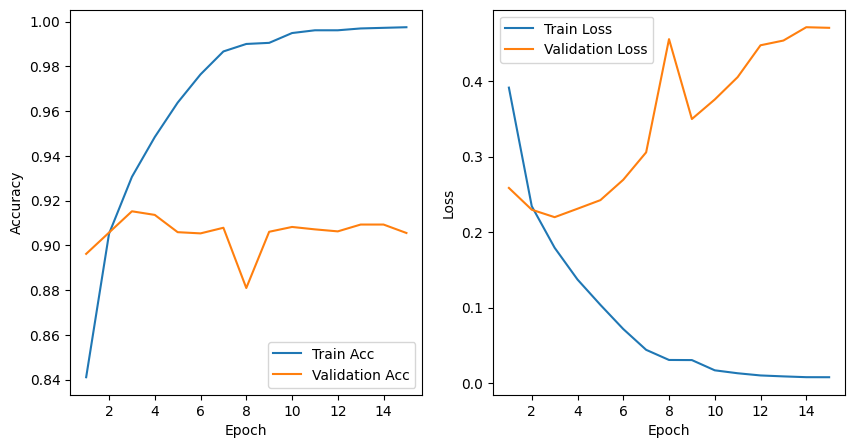

In [31]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

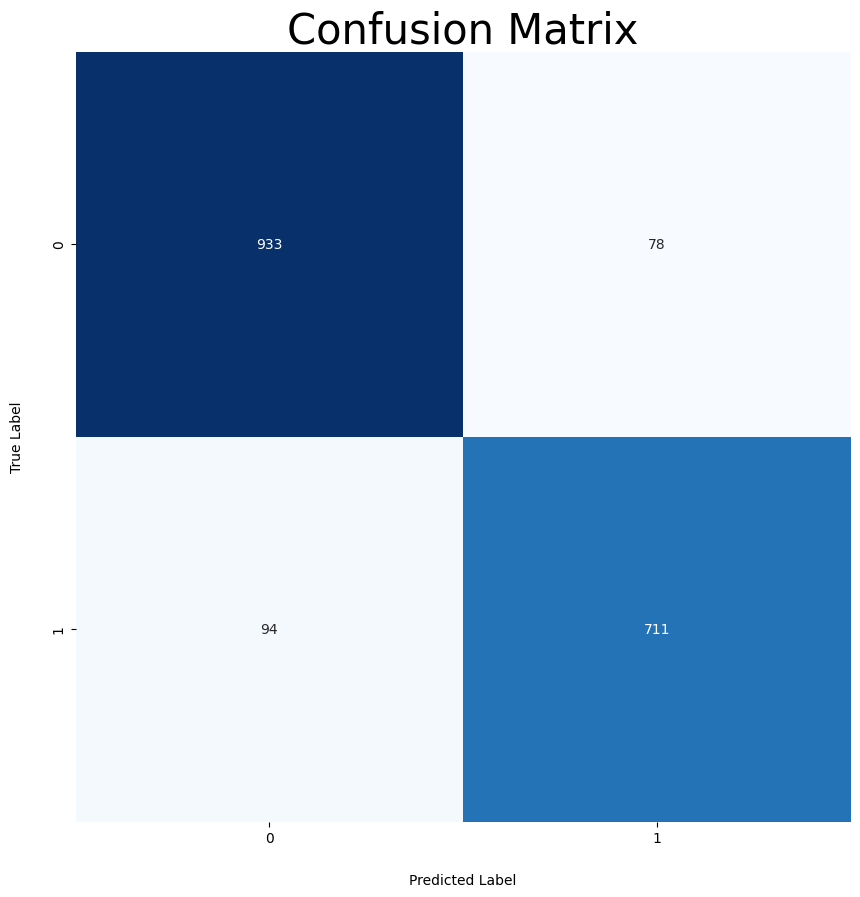

In [32]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [33]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.903
F1:        0.904
Precision: 0.905
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1011
           1       0.90      0.88      0.89       805

    accuracy                           0.91      1816
   macro avg       0.90      0.90      0.90      1816
weighted avg       0.91      0.91      0.91      1816



# Effect of Context Window Size on Model

Here are the pros and cons of having a too large context window size:

* pros
    * Capturing Long-range Dependencies: A larger context window allows the model to capture long-range dependencies and relationships between distant words in the text. This can be beneficial for tasks requiring a deep understanding of context, such as document classification, sentiment analysis, or machine translation.
    * Increased Contextual Information: With a larger context window, the model has access to more contextual information, which may improve its ability to understand the nuances of language and make more informed predictions. This can lead to better performance on tasks that require a thorough understanding of context.
    * Enhanced Semantic Understanding: By considering a larger context, the model can better understand the semantic meaning of sentences or documents. This can help in tasks such as natural language inference, question answering, and summarization, where semantic understanding is crucial.
* cons
    * Computational Complexity: Larger context window sizes increase the computational complexity of the model, both during training and inference. Processing longer sequences requires more memory and computation, which can lead to longer training times and higher resource requirements.
    * Overfitting: Models with large context window sizes may be more prone to overfitting, especially when trained on smaller datasets. The model may memorize specific patterns or relationships in the training data that are not generalizable to unseen data, leading to reduced performance on validation or test sets.
    * Difficulty in Learning: Training models with large context window sizes can be challenging, as the model needs to learn to capture and represent relevant information from a wide range of input tokens. This can result in slower convergence during training and may require more extensive tuning of hyperparameters.
    * Limited Generalization: In some cases, a large context window may lead to models that are too specific to the training data and have limited generalization ability. The model may become overly sensitive to specific word sequences or linguistic structures present in the training data, making it less effective at handling variations in real-world text.    

In [38]:
train_dataset = Twitter(
    df.iloc[X_train_idx],
    w2v_model=w2v_model,
    sequence_len=196
)
valid_dataset = Twitter(
    df.iloc[X_test_idx],
    w2v_model=w2v_model,
    sequence_len=196
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Deleted 0-Len Samples: 23


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:35: SettingWithCopyWarning: 
A value is tryi

Deleted 0-Len Samples: 8
Train dataset length: 7272
Valid dataset length: 1816


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [39]:
model2 = CNN(sequence_len=196)
cnn_model_train_history = train_model(
    model = model2,
    batch_size = BATCH_SIZE,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = adam,
    epochs = EPOCHS,
    train_set = train_dataset,
    valid_set = valid_dataset,
    device= 'auto'
)

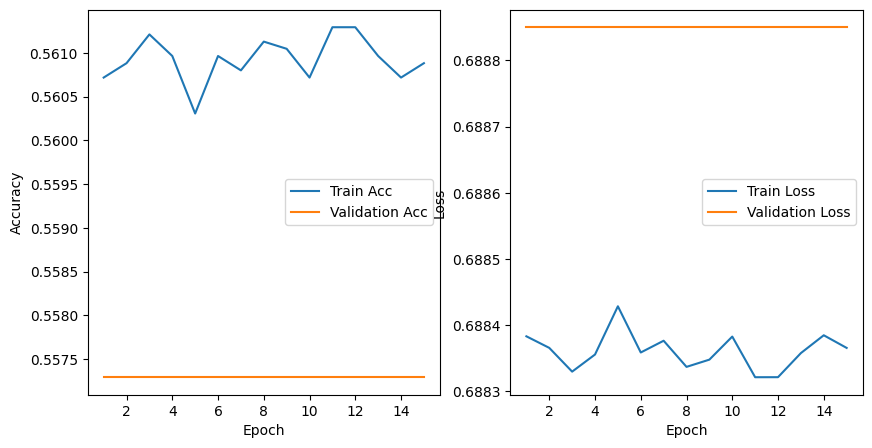

In [40]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

C:\Users\javadpsk\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\javadpsk\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\javadpsk\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

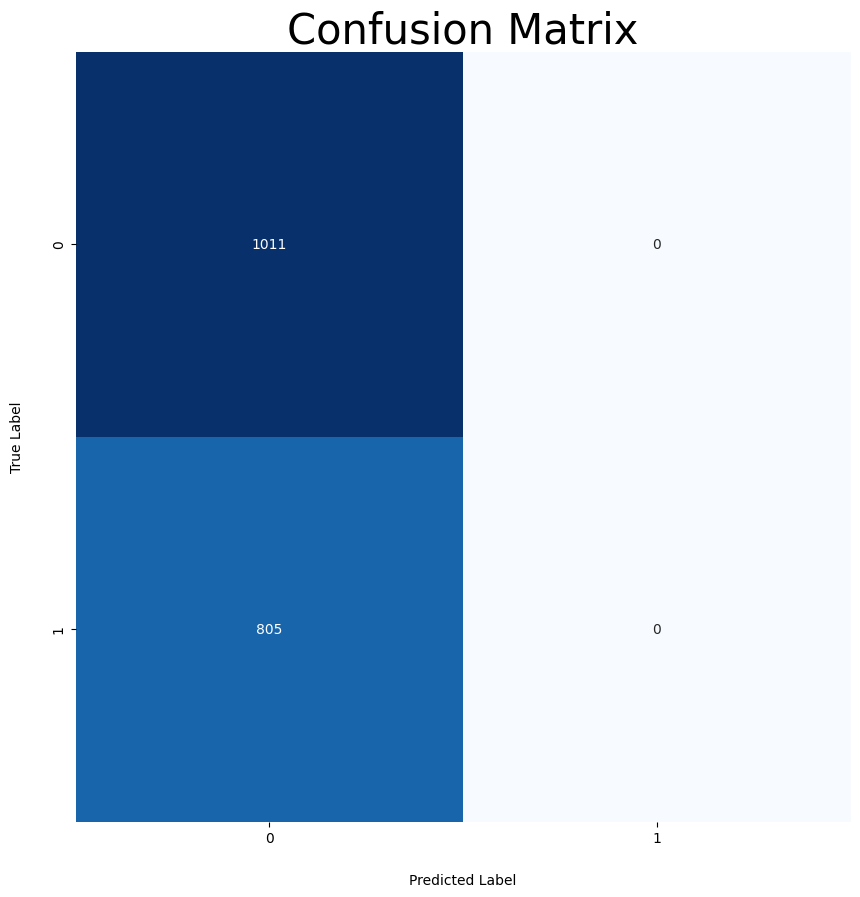

In [42]:
cnn_model_report = generate_confusion_matrix(
    model=model2,
    dataset=valid_dataset,
)

In [43]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.500
F1:        0.358
Precision: 0.278
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1011
           1       0.00      0.00      0.00       805

    accuracy                           0.56      1816
   macro avg       0.28      0.50      0.36      1816
weighted avg       0.31      0.56      0.40      1816



The model predicts every input as zero.why?

# Regularization

In [71]:
import torch
import torch.nn as nn

class CNN_Normalized(nn.Module):
    def __init__(self, sequence_len):
        super(CNN_Normalized, self).__init__()

        # Define your network's layers here
        self.conv1_1 = nn.Conv1d(300, 64, 3)
        self.conv1_2 = nn.Conv1d(64, 128, 3)
        self.max_pool_1 = nn.MaxPool1d(kernel_size=sequence_len - 4)

        self.conv2_1 = nn.Conv1d(300, 64, 5)
        self.conv2_2 = nn.Conv1d(64, 128, 5)
        self.max_pool_2 = nn.MaxPool1d(kernel_size=sequence_len - 8)

        self.conv3_1 = nn.Conv1d(300, 64, 7)
        self.conv3_2 = nn.Conv1d(64, 128, 7)
        self.max_pool_3 = nn.MaxPool1d(kernel_size=sequence_len - 12)

        # Fully connected layers
        self.fc1 = nn.Linear(3 * 128, 128)
        self.fc2 = nn.Linear(128, 2)

        # Dropout layers
        self.dropout = nn.Dropout(0.2)

        # Batch normalization layers
        self.batch_norm_fc1 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        # First branch
        x1 = torch.relu(self.conv1_1(x))
        x1 = torch.relu(self.conv1_2(x1))
        x1 = self.max_pool_1(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten

        # Second branch
        x2 = torch.relu(self.conv2_1(x))
        x2 = torch.relu(self.conv2_2(x2))
        x2 = self.max_pool_2(x2)
        x2 = x2.view(x2.size(0), -1)  # Flatten

        # Third branch
        x3 = torch.relu(self.conv3_1(x))
        x3 = torch.relu(self.conv3_2(x3))
        x3 = self.max_pool_3(x3)
        x3 = x3.view(x3.size(0), -1)  # Flatten

        # Concatenate the flattened outputs
        x_cat = torch.cat((x1, x2, x3), dim=1)

        # Fully connected layers with dropout and batch normalization
        x_fc1 = torch.relu(self.fc1(x_cat))
        x_fc1 = self.batch_norm_fc1(x_fc1)
        x_fc1 = self.dropout(x_fc1)
        out = self.fc2(x_fc1)

        return out


In [57]:
train_dataset = Twitter(
    df.iloc[X_train_idx],
    w2v_model=w2v_model,
    sequence_len=SEQUENCE_LEN
)
valid_dataset = Twitter(
    df.iloc[X_test_idx],
    w2v_model=w2v_model,
    sequence_len=SEQUENCE_LEN
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Deleted 0-Len Samples: 23


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:35: SettingWithCopyWarning: 
A value is tryi

Deleted 0-Len Samples: 8
Train dataset length: 7272
Valid dataset length: 1816


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_9308\2478837795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [72]:
model3 = CNN_Normalized(sequence_len=SEQUENCE_LEN)
cnn_model_train_history = train_model(
    model = model3,
    batch_size = BATCH_SIZE,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = adam,
    epochs = EPOCHS,
    train_set = train_dataset,
    valid_set = valid_dataset,
    device= 'auto'
)

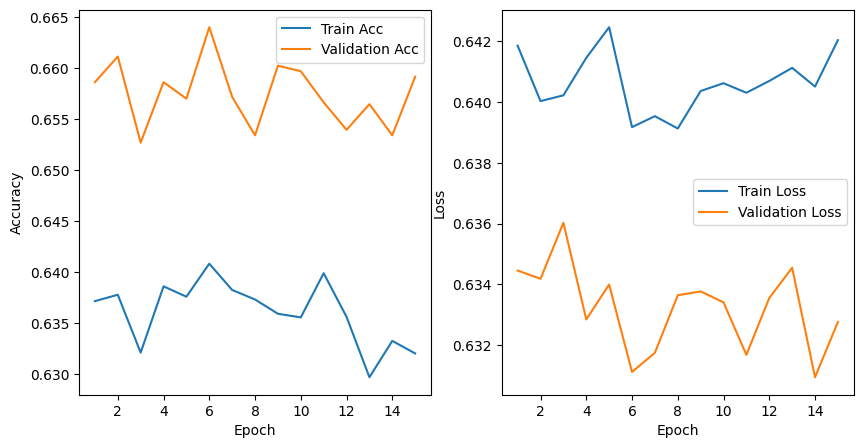

In [73]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

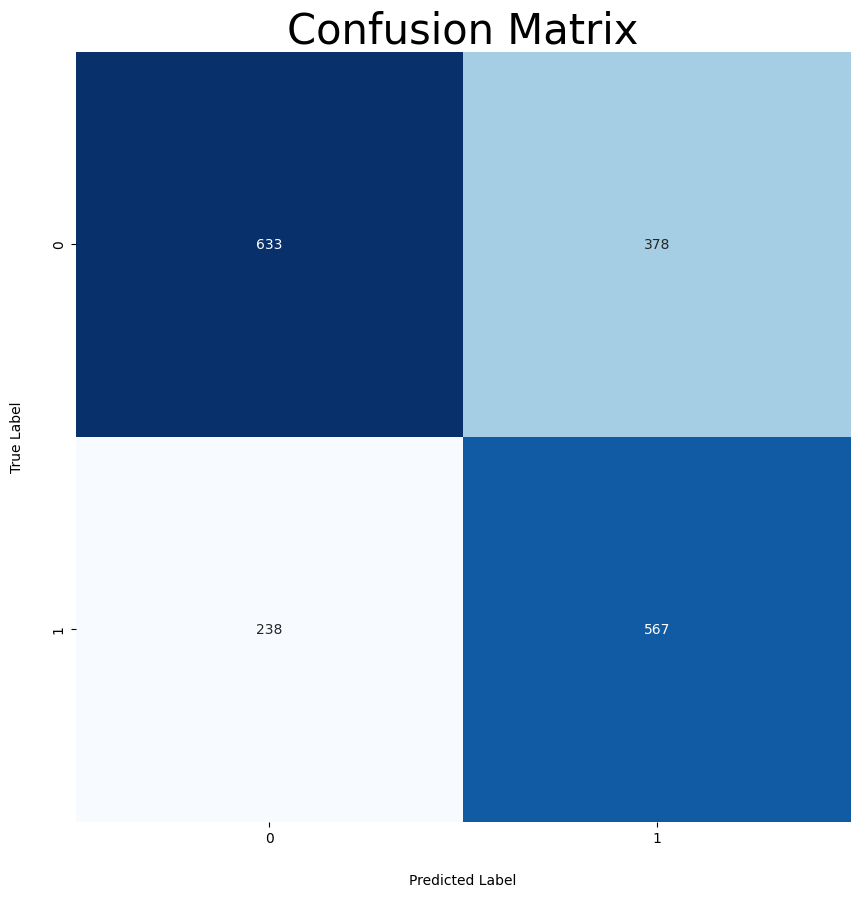

In [74]:
cnn_model_report = generate_confusion_matrix(
    model=model3,
    dataset=valid_dataset,
)

In [75]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.665
F1:        0.660
Precision: 0.663
              precision    recall  f1-score   support

           0       0.73      0.63      0.67      1011
           1       0.60      0.70      0.65       805

    accuracy                           0.66      1816
   macro avg       0.66      0.67      0.66      1816
weighted avg       0.67      0.66      0.66      1816

